# Part a) SGD


In [1]:
import autograd.numpy as np
from imageio import imread
import matplotlib.pyplot as plt
import os
from common import *
from models import sgd, momentum_sgd
import cv2
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from cmcrameri import cm


print(f"Root directory: {os.getcwd()}")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

#%matplotlib

Root directory: /home/arefrode/uio/fys-stk4155/projects/FYS-STK4155-Prj2_report/code


# Global variables

In [2]:
SEED_VALUE = 4155
np.random.seed(SEED_VALUE)
SAVE_FIGURES = False

# Reading data and resizing

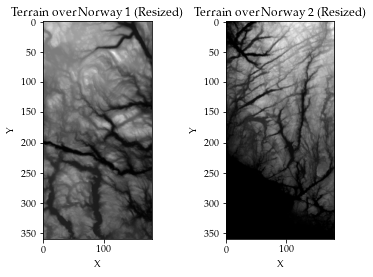

In [3]:
# Load the terrain
terrain1_file = "SRTM_data_Norway_1.tif"
terrain2_file = "SRTM_data_Norway_2.tif"
terrain1 =  imread(f'{INPUT_DATA}{terrain1_file}')
terrain2 = imread(f'{INPUT_DATA}{terrain2_file}')

# Resizing the image
rescale_factor = 0.1
y_size = int(terrain1.shape[0] * rescale_factor)
x_size = int(terrain1.shape[1] * rescale_factor)
terrain1Resized = cv2.resize(terrain1, (x_size, y_size))
terrain2Resized = cv2.resize(terrain2, (x_size, y_size))

# Plotting terrain
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1 (Resized)")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1Resized, cmap='gray')
ax2.title.set_text("Terrain over Norway 2 (Resized)")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain2Resized, cmap='gray')

if SAVE_FIGURES:
    plt.savefig(f"{REPORT_FIGURES}{EX_A}terrain_data_resized.pdf")
plt.show()

# Creating image patches and Terrain data selection

In [4]:
nXpatches = 3; nYpatches=6
y_steps = int(terrain2Resized.shape[0] / nYpatches); print(y_steps)
x_steps = int(terrain2Resized.shape[1] / nXpatches); print(x_steps)

patches_1 = create_img_patches(terrain1Resized, y_steps, x_steps)
if SAVE_FIGURES:
    fig1 = plotTerrainPatches(patches_1, nYpatches, nXpatches, plotTitle="Terrain1 patches")
    plt.savefig(f"{REPORT_FIGURES}{EX_A}Terrain1_patches.pdf")
    plt.show()

patches_2 = create_img_patches(terrain2Resized, y_steps, x_steps)
if SAVE_FIGURES:
    fig2 = plotTerrainPatches(patches_2, nYpatches, nXpatches, plotTitle="Terrain2 patches")
    plt.savefig(f"{REPORT_FIGURES}{EX_A}Terrain2_patches.pdf")
    plt.show()

# Choosing two interesting terrain patches
img1 = patches_1[2]
img2 = patches_2[5]
x1, y1, z1 = createTerrainData(img1)
x2, y2, z2 = createTerrainData(img2)

# Constructing the terrain data
terrain_data = 1
if terrain_data == 1: # Choosing terrain1*
    x, y, z = x1, y1, z1.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z1

elif terrain_data == 2: # Choosing terrain2
    x, y, z = x2, y2, z2.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z2
    
z_flat = z.ravel(); z_flat = z_flat.reshape(-1,1)

60
60
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Testing on the Terrain data from Project 1

Start off by setting the terrain data

In [6]:
np.random.seed(SEED_VALUE)

degree = 6

X = create_X(x,y, degree)
X = X[:,1:]
X_train, X_test, t_train, t_test = train_test_split(X, z_flat, test_size=0.2, shuffle=True, random_state=SEED_VALUE)

print(f"X has {X.shape[1]} features")

X_train, X_test = standard_scaling(X_train, X_test)
t_train, t_test = standard_scaling(t_train, t_test)

XT_X = X_train.T @ X_train
H = (2./X_train.shape[0]) * XT_X

print(f"Highest possible eta: {2./np.max(np.linalg.eigvals(H)[0])}")

X has 27 features
Highest possible eta: 0.055849464719888726


Applying grid search to find the optimal values for the hyperparameters learning rate $\eta$ and penalizer $\lambda$

In [7]:
theta_initial_values = np.random.randn(X_train.shape[1],1)
# Sample values to test convergence of epochs
batch_size = 5
eta = 0.001

Want to find a suitable number of epochs where convergence is reached

In [11]:
step = 25
epochs = np.arange(step, 300+step, step)
mse_epoch = []
for epoch in epochs:
    np.random.seed(SEED_VALUE)
    theta = sgd(X_train, t_train, theta_initial_values, epoch, batch_size, eta=eta, lr_scheduler=False)
    t_test_hat = X_test @ theta
    print(MSE(t_test, t_test_hat))
    mse_epoch.append(MSE(t_test, t_test_hat))

Training 25 epochs: 100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


0.5783358473796484


Training 50 epochs: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


0.5667031428774496


Training 75 epochs: 100%|██████████| 75/75 [00:27<00:00,  2.74it/s]


0.5568951697123549


Training 100 epochs: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


0.5409201724654301


Training 125 epochs: 100%|██████████| 125/125 [00:45<00:00,  2.72it/s]


0.5383073288344962


Training 150 epochs: 100%|██████████| 150/150 [00:57<00:00,  2.59it/s]


0.5269890538966718


Training 175 epochs: 100%|██████████| 175/175 [01:05<00:00,  2.69it/s]


0.5165627699940576


Training 200 epochs: 100%|██████████| 200/200 [01:20<00:00,  2.49it/s]


0.5110200493056769


Training 225 epochs: 100%|██████████| 225/225 [01:18<00:00,  2.87it/s]


0.5042397987237955


Training 250 epochs: 100%|██████████| 250/250 [01:19<00:00,  3.13it/s]


0.4973390149571918


Training 275 epochs: 100%|██████████| 275/275 [01:28<00:00,  3.10it/s]


0.49153473228873384


Training 300 epochs: 100%|██████████| 300/300 [01:35<00:00,  3.14it/s]

0.48698913684098005


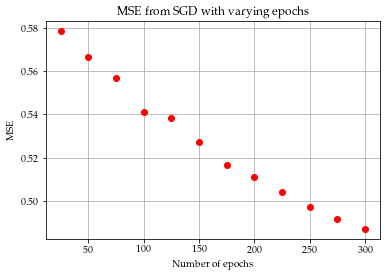

In [12]:
plt.figure()
plt.plot(epochs, mse_epoch, 'ro')
plt.xlabel("Number of epochs")
plt.ylabel("MSE")
plt.grid()
plt.title(f"MSE from SGD with varying epochs")
if SAVE_FIGURES:
    plt.savefig(f"{REPORT_FIGURES}{EX_A}mse_with_varying_epoch.pdf")

Computing the values

In [7]:
theta_initial_values = np.random.randn(X_train.shape[1],1)
batch_size = 5

etas = np.logspace(-5, -2, 4)
lambdas = np.logspace(-4, -1, 4)
epoch = 100 # Based on the plot above, good computational efficiency / precision ratio

heatmap_mtrx = np.zeros(shape=(len(etas), len(lambdas)))

for eta in range(len(etas)):
    for lmb in range(len(lambdas)):
        np.random.seed(SEED_VALUE)
        print(f"Training for eta: {etas[eta]}, lambda: {lambdas[lmb]}")
        theta = sgd(X_train, t_train, theta_initial_values, epoch, batch_size, eta=etas[eta], lmb=lambdas[lmb], lr_scheduler=False)
        heatmap_mtrx[eta, lmb] = MSE(t_test, X_test @ theta)
        print(MSE(t_test, X_test @ theta))

Training for eta: 1e-05, lambda: 0.0001


Training 100 epochs: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


0.898736817658819
Training for eta: 1e-05, lambda: 0.001


Training 100 epochs: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


0.8985401211613748
Training for eta: 1e-05, lambda: 0.01


Training 100 epochs: 100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


0.8965818536265437
Training for eta: 1e-05, lambda: 0.1


Training 100 epochs: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


0.8778442145130902
Training for eta: 0.0001, lambda: 0.0001


Training 100 epochs: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


0.639376440524294
Training for eta: 0.0001, lambda: 0.001


Training 100 epochs: 100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


0.6389248565586915
Training for eta: 0.0001, lambda: 0.01


Training 100 epochs: 100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


0.6346055756892593
Training for eta: 0.0001, lambda: 0.1


Training 100 epochs: 100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


0.6063693972249148
Training for eta: 0.001, lambda: 0.0001


Training 100 epochs: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


0.5374949061017065
Training for eta: 0.001, lambda: 0.001


Training 100 epochs: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


0.5377653985052415
Training for eta: 0.001, lambda: 0.01


Training 100 epochs: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


0.5408741422504982
Training for eta: 0.001, lambda: 0.1


Training 100 epochs: 100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


0.563946197544948
Training for eta: 0.01, lambda: 0.0001


Training 100 epochs: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


0.4380139511969073
Training for eta: 0.01, lambda: 0.001


Training 100 epochs: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


0.45269832081845873
Training for eta: 0.01, lambda: 0.01


Training 100 epochs: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


0.528489895001101
Training for eta: 0.01, lambda: 0.1


Training 100 epochs: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]

0.5906033288375373


Constructing a heatmap of the values

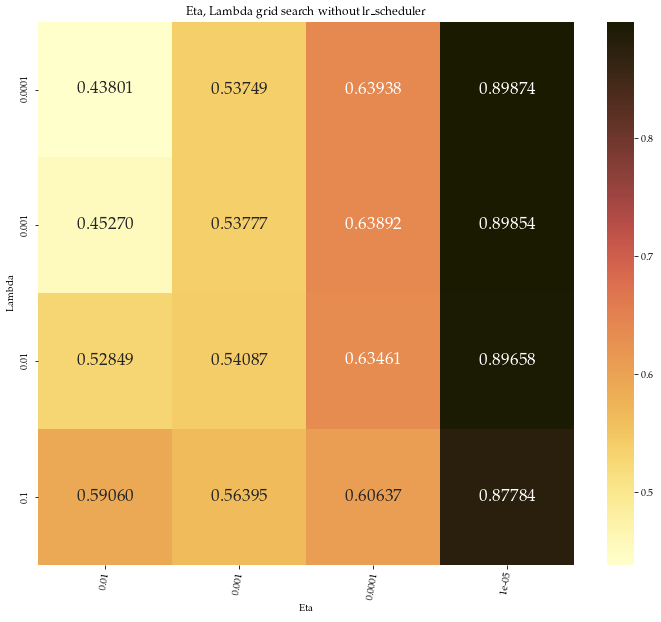

In [8]:
plt.figure(figsize=(12,10))
gridsearch = sns.heatmap(heatmap_mtrx.T,annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= etas, yticklabels= lambdas, cmap=cm.lajolla)
gridsearch.invert_xaxis()
gridsearch.set_xticklabels(gridsearch.get_xticklabels(),rotation = 80)

plt.title("Eta, Lambda grid search without lr\_scheduler")
plt.xlabel("Eta")
plt.ylabel("Lambda")
if SAVE_FIGURES:
    plt.savefig(f"{REPORT_FIGURES}{EX_A}_gridsearch.pdf")

# Creating a similar heatmap, but with lr_scheduler

In [8]:
theta_initial_values = np.random.randn(X_train.shape[1],1)
batch_size = 5

etas = np.logspace(-5, -2, 4)
lambdas = np.logspace(-4, -1, 4)
epoch = 100 # Based on the plot above, good computational efficiency / precision ratio

heatmap_mtrx_nolr = np.zeros(shape=(len(etas), len(lambdas)))

for eta in range(len(etas)):
    for lmb in range(len(lambdas)):
        np.random.seed(SEED_VALUE)
        print(f"Training for eta: {etas[eta]}, lambda: {lambdas[lmb]}")
        theta = sgd(X_train, t_train, theta_initial_values, epoch, batch_size, eta=etas[eta], lmb=lambdas[lmb], lr_scheduler=True)
        heatmap_mtrx_nolr[eta, lmb] = MSE(t_test, X_test @ theta)
        print(MSE(t_test, X_test @ theta))

Training for eta: 1e-05, lambda: 0.0001


Training 100 epochs: 100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


1.3811365904307216
Training for eta: 1e-05, lambda: 0.001


Training 100 epochs: 100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


1.3810059977270892
Training for eta: 1e-05, lambda: 0.01


Training 100 epochs: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


1.3797016965390798
Training for eta: 1e-05, lambda: 0.1


Training 100 epochs: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


1.3668198961304514
Training for eta: 0.0001, lambda: 0.0001


Training 100 epochs: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


0.7540664120719645
Training for eta: 0.0001, lambda: 0.001


Training 100 epochs: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


0.7537461529921857
Training for eta: 0.0001, lambda: 0.01


Training 100 epochs: 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


0.7505834096334729
Training for eta: 0.0001, lambda: 0.1


Training 100 epochs: 100%|██████████| 100/100 [00:34<00:00,  2.94it/s]


0.7226249719656503
Training for eta: 0.001, lambda: 0.0001


Training 100 epochs: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


0.5831982061676028
Training for eta: 0.001, lambda: 0.001


Training 100 epochs: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


0.5828611296485161
Training for eta: 0.001, lambda: 0.01


Training 100 epochs: 100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


0.579905812366509
Training for eta: 0.001, lambda: 0.1


Training 100 epochs: 100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


0.5716474240250325
Training for eta: 0.01, lambda: 0.0001


Training 100 epochs: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


0.4859312368306962
Training for eta: 0.01, lambda: 0.001


Training 100 epochs: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


0.4888854226636121
Training for eta: 0.01, lambda: 0.01


Training 100 epochs: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


0.5131519065887356
Training for eta: 0.01, lambda: 0.1


Training 100 epochs: 100%|██████████| 100/100 [00:44<00:00,  2.26it/s]

0.5638597869567146


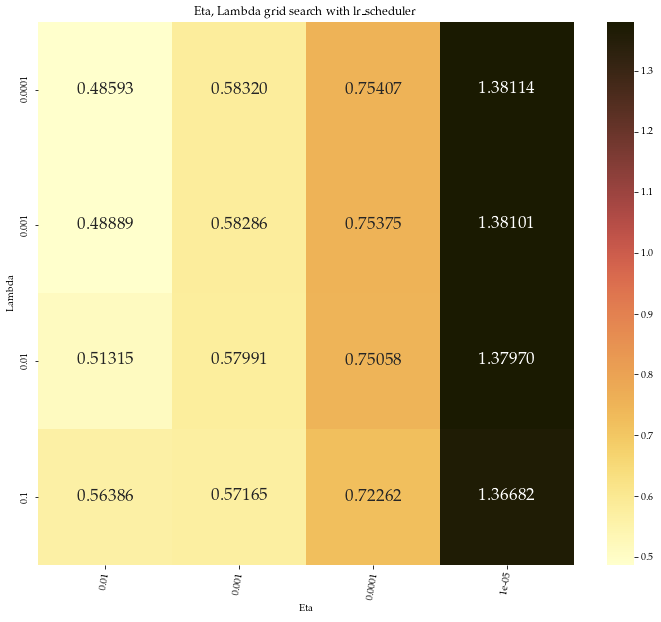

In [9]:
plt.figure(figsize=(12,10))
gridsearch = sns.heatmap(heatmap_mtrx_nolr.T,annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= etas, yticklabels= lambdas, cmap=cm.lajolla)
gridsearch.invert_xaxis()
gridsearch.set_xticklabels(gridsearch.get_xticklabels(),rotation = 80)

plt.title("Eta, Lambda grid search with lr\_scheduler")
plt.xlabel("Eta")
plt.ylabel("Lambda")
if SAVE_FIGURES:
    plt.savefig(f"{REPORT_FIGURES}{EX_A}_gridsearch_withlr.pdf")

Stochastic Gradient Descent with regularization

In [8]:
np.random.seed(SEED_VALUE)

degree = 6

X = create_X(x,y, degree)
X = X[:,1:]
X_train, X_test, t_train, t_test = train_test_split(X, z_flat, test_size=0.2, shuffle=True, random_state=SEED_VALUE)

print(f"X has {X.shape[1]} features")

X_train, X_test = standard_scaling(X_train, X_test)
t_train, t_test = standard_scaling(t_train, t_test)

theta_initial_values = np.random.randn(X_train.shape[1],1)
epochs = 100
batch_size = 4

XT_X = X_train.T @ X_train
H = (2./X_train.shape[0]) * XT_X

# Optimal values based on Heatmap gridsearch
eta = 0.01
lmb = 0.0001

theta = sgd(X_train, t_train, theta_initial_values, epochs, batch_size, eta=eta, lmb=lmb, lr_scheduler=True)
print(f"MSE for SGD with l2 regularizer and lr scheduler: {MSE(t_test, X_test @ theta)}")

np.random.seed(SEED_VALUE)

theta = momentum_sgd(X_train, t_train, theta_initial_values, epochs, batch_size, eta=eta, lmb=lmb, lr_scheduler=True)
print(f"MSE for momentum SGD with l2 regularizer and lr scheduler: {MSE(t_test, X_test @ theta)}")

np.random.seed(SEED_VALUE)

theta = sgd(X_train, t_train, theta_initial_values, epochs, batch_size, eta=eta, lmb=lmb, lr_scheduler=False)
print(f"MSE for SGD with l2 regularizer: {MSE(t_test, X_test @ theta)}")

sgdreg = SGDRegressor(max_iter = epochs, fit_intercept=False, penalty='l2', alpha=lmb, eta0=eta, learning_rate='constant', random_state=SEED_VALUE)
sgdreg.fit(X_train,t_train.ravel())
print(f"MSE for SKlearn: {MSE(t_test, X_test @ sgdreg.coef_)}")

beta_hat = np.linalg.pinv(XT_X + lmb*np.eye(XT_X.shape[0])) @ (X_train.T @ t_train)
print(f"MSE for Ridge: {MSE(t_test, X_test @ beta_hat)}")

X has 27 features


Training 100 epochs: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


MSE for SGD with l2 regularizer and lr scheduler: 0.47836338130471223


Training 100 epochs: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


MSE for momentum SGD with l2 regularizer and lr scheduler: 0.4377632497225466


Training 100 epochs: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]

MSE for SGD with l2 regularizer: 0.4203875113994177
MSE for SKlearn: 1.0764746346665202
MSE for Ridge: 0.3256289168054239


Testing the SGD with and without the learning rate scheduler

In [9]:
np.random.seed(SEED_VALUE)

degree = 6

X = create_X(x,y, degree)
X = X[:,1:]
X_train, X_test, t_train, t_test = train_test_split(X, z_flat, test_size=0.2, shuffle=True, random_state=SEED_VALUE)

print(f"X has {X.shape[1]} features")

X_train, X_test = standard_scaling(X_train, X_test)
t_train, t_test = standard_scaling(t_train, t_test)

theta_initial_values = np.random.randn(X_train.shape[1],1)
epochs = 100
batch_size = 4

XT_X = X_train.T @ X_train
H = (2./X_train.shape[0]) * XT_X

# Optimal values based on Heatmap gridsearch
eta = 0.01
lmb = 0.0001

theta = sgd(X_train, t_train, theta_initial_values, epochs, batch_size, eta=eta, lr_scheduler=True)
print(f"MSE for SGD with lr scheduler without l2 regularizer: {MSE(t_test, X_test @ theta)}")

np.random.seed(SEED_VALUE)

theta = momentum_sgd(X_train, t_train, theta_initial_values, epochs, batch_size, eta=eta, lr_scheduler=True)
print(f"MSE for momentum SGD with l2 regularizer and lr scheduler: {MSE(t_test, X_test @ theta)}")

np.random.seed(SEED_VALUE)

theta = sgd(X_train, t_train, theta_initial_values, epochs, batch_size, eta=eta, lr_scheduler=False)
print(f"MSE for SGD without lr scheduler and l2 regularizer: {MSE(t_test, X_test @ theta)}")

sgdreg = SGDRegressor(max_iter = epochs, fit_intercept=False, penalty=None, alpha=0, eta0=eta, learning_rate='constant', random_state=SEED_VALUE)
sgdreg.fit(X_train,t_train.ravel())
print(f"MSE for SKlearn: {MSE(t_test, X_test @ sgdreg.coef_)}")

beta_hat = np.linalg.pinv(XT_X) @ (X_train.T @ t_train)
print(f"MSE for OLS: {MSE(t_test, X_test @ beta_hat)}")

X has 27 features


Training 100 epochs: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


MSE for SGD with lr scheduler without l2 regularizer: 0.477826054468515


Training 100 epochs: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


MSE for momentum SGD with l2 regularizer and lr scheduler: 0.43541113663107145


Training 100 epochs: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]

MSE for SGD without lr scheduler and l2 regularizer: 0.4171813381953609
MSE for SKlearn: 1.0869142501641247
MSE for OLS: 0.32167530880510836


# Finally, testing the dependance on batch size

In [17]:
np.random.seed(SEED_VALUE)

degree = 6

X = create_X(x,y, degree)
X = X[:,1:]
X_train, X_test, t_train, t_test = train_test_split(X, z_flat, test_size=0.2, shuffle=True, random_state=SEED_VALUE)

print(f"X has {X.shape[1]} features")

X_train, X_test = standard_scaling(X_train, X_test)
t_train, t_test = standard_scaling(t_train, t_test)

theta_initial_values = np.random.randn(X_train.shape[1],1)
epochs = 100

# Optimal values based on Heatmap gridsearch
eta = 0.01
lmb = 0.0001

batch_sizes = [2,3,4,5,6,8,16,32]
mse_batch = []
for batch_size in batch_sizes:
    np.random.seed(SEED_VALUE)
    theta = sgd(X_train, t_train, theta_initial_values, epochs, batch_size, eta=eta, lr_scheduler=False)
    t_test_hat = X_test @ theta
    print(MSE(t_test, t_test_hat))
    mse_batch.append(MSE(t_test, t_test_hat))

X has 27 features


Training 100 epochs: 100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


1.4053907767379716


Training 100 epochs: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


0.4487320180266821


Training 100 epochs: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


0.4171813381953609


Training 100 epochs: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


0.43543882501185893


Training 100 epochs: 100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


0.4255532083238662


Training 100 epochs: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


0.4807334619364602


Training 100 epochs: 100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


0.5009696170682801


Training 100 epochs: 100%|██████████| 100/100 [00:05<00:00, 18.74it/s]

0.5237995685398364


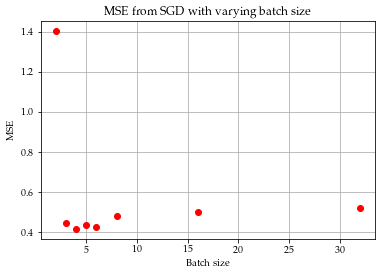

In [18]:
plt.figure()
plt.plot(batch_sizes, mse_batch, 'ro')
plt.xlabel("Batch size")
plt.ylabel("MSE")
plt.grid()
plt.title(f"MSE from SGD with varying batch size")
if SAVE_FIGURES:
    plt.savefig(f"{REPORT_FIGURES}{EX_A}mse_with_varying_batch_size.pdf")